In this part, we are going to use the results from aggregation step and write a simple Convolutional Neural Network (CNN) to automatically classify the MuonHunter images.

Let's start again by importing our dependencies:

In [1]:
# PyTorch modules
import torch
from torch import nn
from torchvision.transforms import Resize
from torchinfo import summary
# for loading images and plotting
import numpy as np
import matplotlib.pyplot as plt
# utilities
import tqdm
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# check if GPU is detected, if not use the CPU for training:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

First, we need to load the data. Let's create a function to load a batch of `n` images. 

For our training, let's use 2500 images with muons and 2500 images without muons (we need to use a balanced dataset so that network learns efficiently). To figure out if a subject has muons, we need to load our consensus data.

In [3]:
consensus = np.load('aggregated_data.npy')

# subset list of muons
muon_subset = consensus[consensus[:,2] == 1]

# subset list of non-muons
non_muon_subset = consensus[consensus[:,2] == 0]

Then, let's randomly sample 2500 from each set and put that into a list of subjects for the model

In [4]:
all_data = np.concatenate([muon_subset[:2500], non_muon_subset[:2500]])

# let's split this into training and validation (90% training and 10% validation)
train_data, val_data = train_test_split(all_data, test_size=0.1, shuffle=True, random_state=5)

In [5]:
print(f"{len(train_data)} training subjects and {len(val_data)} validation subjects")

4500 training subjects and 500 validation subjects


Now let's define a function that loads and the images and returns them in batches

In [6]:
def get_image_label_batch(batch_index, batch_size, data):
    '''
        Get's a `batch_size` batch of images and corresponding labels from `data` 
        for the `batch_index`-th batch.
    '''
    # get the subject_ids 
    sub_ids = data[batch_index*batch_size:(batch_index+1)*batch_size, 0].astype(int)
    # get the labels
    labels = data[batch_index*batch_size:(batch_index+1)*batch_size, 2]
    
    imgs = np.zeros((len(sub_ids), 3, 128, 128))
    for i, sub_id in enumerate(sub_ids):
        # load the image (remove the transparency channel)
        img = plt.imread(f'subject_images_resized/{sub_id}.png')[:,:,:3]
        # convert this to the PyTorch format (channel, height, width)
        imgs[i, :] = np.transpose(img, (2, 0, 1))
        
    return imgs, labels

In [7]:
# test the retrieval of a batch of images
imgs, labels = get_image_label_batch(0, 5, train_data)

In [8]:
# let's see what the shape is
print(imgs.shape)

(5, 3, 128, 128)


Let's see what these training subjects look like:

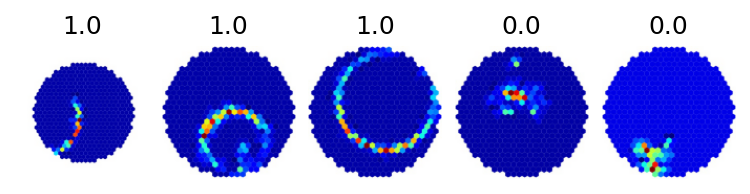

In [9]:
fig, axs = plt.subplots(1, 5, dpi=150, facecolor='white', sharex=True, sharey=True)
for axi, imgi, labeli in zip(axs, imgs, labels):
    axi.imshow(np.transpose(imgi, (1, 2, 0)))
    axi.set_title(labeli)
    axi.axis('off')
    
plt.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.1, hspace=0.1, wspace=0.1)
plt.show()

# Designing a CNN

Now, let's move on to designing the architecture of our neural network. There are different parts to a CNN, which includes the feature extraction stage and the prediction stage. Each stage uses a different set of components, which we will detail below:

### Feature Extraction and Convolutional Kernels

The main component is the use of convolutional operations to extract spatial features. A convolutional layer in a neural network consists of a set of kernels which slide over the image and extract information about the spatial correlation of the pixels in the image. This is what a simple convolutional operation looks like:

![CNN](https://miro.medium.com/max/1010/1*jIv2CLxdXsxvx60Urc11Tw.png)

The values within a kernel dictate what sort of feature is being extracted from the image. For example, specific kernels will create a blurred version of the input, whereas others will extract edges. 

![gaussian_kernel](./gaussian.gif)

![edge_kernel](./edge.gif)

For a CNN, the values for the kernel will be determined when training the model. The CNN will learn the best kernels that will need to be used in order to extract the correct information from the input, which are optimal for making the prediction.

### Prediction stage and Fully Connected Layers

Once the (spatial) feature extraction is done, we create a set of fully connected neurons (FCN) which will use the information extracted by the convolutional layers to label the image. An FCN looks like the following:

![FCN](http://neuralnetworksanddeeplearning.com/images/tikz1.png)

where the inputs are the series of features extracted by the convolutional layers, and the output is the prediction (muon or not). Each layer of neurons is called a "hidden layer". The output neuron $y_i$ from each hidden layer input neuron ($x_j$) is a linear combination of the values from each neuron:

$$ y_i = \sum_{i, j} w_{ij} x_j + b_i $$

The model learns the weights associated with each combination of input and output ($w_{ij}$) and the bias ($b_i$)

## PyTorch implementation

PyTorch has a series of layers (which are essentially Python classes) which will handle all of the mathematics of both the convolutional kernels and the FCNs. All we need to do is fix the sizes and shapes of each layer. We will create a model which has 2 layers of convolutional feature extraction steps and 2 layer deep FCN. The final layer will produce a single output neuron which provides the probability that the image is a muon (0 = non-muon, 1 = muon).

In [10]:
class CNN(nn.Module):
    def __init__(self, filters, bottleneck_dims, input_size = 64, input_channels=3, n_output=1):
        super().__init__()
        
        # first convolutional layer
        # has a convolutional kernel, activation, batch normalization and pooling
        self.conv1 = nn.Conv2d(input_channels, filters[0], (3, 3), (1, 1), padding=1)
        self.cact1 = nn.LeakyReLU(0.2)
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.maxpool1 = nn.MaxPool2d((2, 2))
        
        # second convolutional layer
        self.conv2 = nn.Conv2d(filters[0], filters[1], (3, 3), (1, 1), padding=1)
        self.cact2 = nn.LeakyReLU(0.2)
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.maxpool2 = nn.MaxPool2d((2, 2))
        
        # get the total number of extracted features at the end
        # we apply MaxPooling twice and so reduce the image size by 2 each time
        # therefore, the final layer has (1/4)th the number of pixels along each axis
        # the total is then (width/4)*(height/4)*(# of convolutional filters)
        flattened_size = int((input_size / 4)**2) * filters[1]
        
        # first FCN layer
        self.dense1 = nn.Linear(flattened_size, bottleneck_dims[0])
        self.dact1 = nn.LeakyReLU(0.2)
        
        # second FCN layer
        self.dense2 = nn.Linear(bottleneck_dims[0], bottleneck_dims[1])
        self.dact2 = nn.LeakyReLU(0.2)
        
        # final prediction layer
        self.pred_dense = nn.Linear(bottleneck_dims[1], n_output)
        self.pred_act = nn.Sigmoid()
        
    def forward(self, x):
        # apply the first convolutional layer on the input
        x = self.conv1(x)
        x = self.cact1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        
        # apply the second convolutional layer 
        # on the output of the first convolutional layer
        x = self.conv2(x)
        x = self.cact2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)
        
        # flatten the output of the second convolutional layer
        # so that we can pass this into the FCN
        x = x.reshape((x.shape[0], -1))
        
        # first layer of FCN on the flattened feature vector
        x = self.dense1(x)
        x = self.dact1(x)
        
        # second layer of FCN on the output of the first layer of FCN
        x = self.dense2(x)
        x = self.dact2(x)
        
        # predict on the output of the second FCN
        x = self.pred_dense(x)
        return self.pred_act(x)

Now we initialize our CNN. We are going to use 8 filters for the first CNN layer and 64 filters for the second CNN layer and 128 and 8 hidden layers respectively. To speed up the training of the model, we will resize our images to `(64, 64, 3)` during the training step, so let's set `input_size=64` for the CNN.

In [11]:
cnn = CNN([8, 64], [128, 8], input_size=64).to(device)

Let's see what our model looks like

In [12]:
summary(cnn, [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Conv2d: 1-1                            [1, 8, 64, 64]            224
├─LeakyReLU: 1-2                         [1, 8, 64, 64]            --
├─BatchNorm2d: 1-3                       [1, 8, 64, 64]            16
├─MaxPool2d: 1-4                         [1, 8, 32, 32]            --
├─Conv2d: 1-5                            [1, 64, 32, 32]           4,672
├─LeakyReLU: 1-6                         [1, 64, 32, 32]           --
├─BatchNorm2d: 1-7                       [1, 64, 32, 32]           128
├─MaxPool2d: 1-8                         [1, 64, 16, 16]           --
├─Linear: 1-9                            [1, 128]                  2,097,280
├─LeakyReLU: 1-10                        [1, 128]                  --
├─Linear: 1-11                           [1, 8]                    1,032
├─LeakyReLU: 1-12                        [1, 8]                    --


We have about 2 million parameters, which is a good size for a simple model. Let's define some training parameters and start training.

We need to set the number of epochs that we want to train this model for and also some parameters that define how the training works. We will use a more complicated algorithm called `Adam`, which does batch gradient descent, but with more efficiency and additional parameterizations which speed up convergence. For Adam, we need to define a learning rate (or a step size for the gradient descent)

In [13]:
lr = 1.e-4
nepochs = 20
batch_size = 32
opt = torch.optim.Adam(cnn.parameters(), lr=lr)

We need to resize the images during the training step (this is called training augmentation). PyTorch (or TorchVision) has a series of modules which can do this efficiently. We will use the resize module (which does bi-linear interpolation)

In [14]:
resize = Resize((64, 64))

Finally, we need to define the loss for our model. We will use binary cross-entropy loss (BCE), which essentially finds the cross-entropy between a predicted and a ground-truth probability distribution. In this way, we can assess the performance of the model as it trains. We want the predicted labels to match the ground truth labels, so the model will learn to modify its weights and learn the convolutional kernels such that the predicted and ground-truth probability distributions match. 

PyTorch features a very simple implementation of the BCE loss parameterization, which we will just call directly.

In [15]:
bce = nn.BCELoss()

def precision_recall(y_pred, y_true):
    tp = (y_pred)*(y_true)
    fn = (1 - y_pred)*(1 - y_true)
    fp = (y_pred)*(1 - y_true)
    fn = (1 - y_pred)*(y_true)
    
    precision = torch.sum(tp)/torch.sum(tp + fp)
    recall = torch.sum(tp)/torch.sum(tp + fn)
    
    return precision, recall

Now, we can begin training our model. For each batch in the training dataset, we will run the the images through the model and get an output prediction. Then, we will compute the BCE loss between the true labels and the predicted labels, and then backpropagate this loss through the layers in the network. Then, we will use the Adam optimizer to update the weights so that our network performs better in the next step. 

We will repeat this process for each batch for `nepochs` number of steps. 

In [16]:
# we will hold the indices for the training and validation data
# this is useful for shuffling the data after each epoch
inds_training = np.arange(len(train_data))
inds_val = np.arange(len(val_data))

# get the number of training and validation batches
n_training_batches = len(train_data) // batch_size + 1
n_val_batches = len(val_data) // batch_size + 1

for n in range(1, nepochs+1):
    print(f"Epoch {n}")
    # shuffle the training data
    np.random.shuffle(inds_training)
    train_data = train_data[inds_training]
    
    # set the model to training mode so that the weights are updated
    cnn.train()
    
    # use TQDM to print a progress bar
    with tqdm.tqdm(range(n_training_batches), desc='Training') as pbar:
        losses = []
        precisions = []
        recalls = []
        # loop over all the training data
        for b in pbar:
            # get the images and labels for this batch
            imgs, labels = get_image_label_batch(b, batch_size, train_data)

            # convert these to PyTorch Tensors
            IMG = resize(torch.Tensor(imgs).to(device))

            # convert the labels to PyTorch Tensors so that we can 
            # calculate the loss
            Ytrue = torch.Tensor(labels).to(device)

            # zero out the gradient from the previous training step
            cnn.zero_grad()
            
            # predict the labels using the CNN
            # flatten out the predictions to a single vector
            Ypred = cnn(IMG).view(-1)
            
            # calculate the loss on the predicted labels
            loss = bce(Ypred, Ytrue)

            # do the backpropagation and gradient descent
            loss.backward()
            opt.step()
            
            precision, recall = precision_recall(Ypred, Ytrue)
            
            losses.append(loss.item())
            precisions.append(precision.item())
            recalls.append(recall.item())

            # print out the current loss
            pbar.set_postfix_str(f'loss: {np.mean(losses):.3e} precision: {np.mean(precisions):.2f} recall: {np.mean(recalls):.2f}')
    
    # every 5 epochs, let's validate the model on our 
    # validation data
    if n % 5 == 0:
        # set the model to evaluation mode since we're not updating the weights
        cnn.eval()
        with tqdm.tqdm(range(n_val_batches), desc='Validation') as pbar:
            # for validation, we do not use back propagation
            # so tell PyTorch to not save gradients
            with torch.no_grad():
                # loop over all the training data
                losses = []
                for b in pbar:
                    # get the images and labels for this batch
                    imgs, labels = get_image_label_batch(b, batch_size, val_data)

                    # convert these to PyTorch Tensors
                    IMG = resize(torch.Tensor(imgs).to(device))

                    # convert the labels to PyTorch Tensors so that we can 
                    # calculate the loss
                    Ytrue = torch.Tensor(labels).to(device)

                    # predict the labels using the CNN
                    Ypred = cnn(IMG).view(-1)

                    # calculate the loss on the predicted labels
                    loss = bce(Ypred, Ytrue)
                    
                    precision, recall = precision_recall(Ypred, Ytrue)

                    losses.append(loss.item())
                    precisions.append(precision.item())
                    recalls.append(recall.item())

                    # print out the current loss
                    pbar.set_postfix_str(f'loss: {np.mean(losses):.3e} precision: {np.mean(precisions):.2f} recall: {np.mean(recalls):.2f}')

Epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 42.71it/s, loss: 1.593e-01 precision: 0.91 recall: 0.92]


Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.12it/s, loss: 1.020e-01 precision: 0.94 recall: 0.95]


Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.05it/s, loss: 8.581e-02 precision: 0.95 recall: 0.95]


Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 43.92it/s, loss: 6.796e-02 precision: 0.96 recall: 0.96]


Epoch 5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 49.74it/s, loss: 1.511e-01 precision: 0.95 recall: 0.97]


Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 43.37it/s, loss: 4.009e-02 precision: 0.97 recall: 0.97]


Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.58it/s, loss: 2.900e-02 precision: 0.98 recall: 0.98]


Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 45.24it/s, loss: 1.825e-02 precision: 0.99 recall: 0.99]


Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.11it/s, loss: 1.356e-02 precision: 0.99 recall: 0.99]


Epoch 10


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.50it/s, loss: 1.243e-01 precision: 0.99 recall: 0.98]


Epoch 11


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.48it/s, loss: 1.012e-02 precision: 0.99 recall: 0.99]


Epoch 12


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 43.93it/s, loss: 5.269e-03 precision: 1.00 recall: 1.00]


Epoch 13


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.21it/s, loss: 4.182e-03 precision: 1.00 recall: 1.00]


Epoch 14


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 45.09it/s, loss: 3.897e-03 precision: 1.00 recall: 1.00]


Epoch 15


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 50.02it/s, loss: 1.514e-01 precision: 0.99 recall: 0.99]


Epoch 16


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.48it/s, loss: 2.371e-03 precision: 1.00 recall: 1.00]


Epoch 17


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.03it/s, loss: 1.673e-03 precision: 1.00 recall: 1.00]


Epoch 18


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 44.79it/s, loss: 1.138e-03 precision: 1.00 recall: 1.00]


Epoch 19


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 43.14it/s, loss: 9.720e-04 precision: 1.00 recall: 1.00]


Epoch 20


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.87it/s, loss: 1.578e-01 precision: 1.00 recall: 1.00]


Now, let's predict on our full dataset and see how our machine did! We'll extract the predicted labels and compare them to the ground-truth labels

In [17]:
# create lists to hold the data
true_labels = []
pred_labels = []

# set the threshold for muon vs. non-muon
threshold = 0.7

# figure out how many batches in the full dataset
# we'll use the same batch_size
nbatches = len(all_data) // batch_size + 1

# now we're in evaluation mode. don't update the weights!
cnn.eval()

with torch.no_grad():
    with tqdm.tqdm(range(nbatches), desc='Evaluating') as pbar:
        # loop over all the training data
        for b in pbar:
            # get the images and labels for this batch
            imgs, labels = get_image_label_batch(b, batch_size, all_data)

            # convert these to PyTorch Tensors
            IMG = resize(torch.Tensor(imgs).to(device))

            # predict the labels using the CNN
            # flatten out the predictions to a single vector
            Ypred = cnn(IMG).view(-1)
            
            # make the threshold cut for the prediction
            y_pred = Ypred.cpu().numpy() > threshold
            
            # add these values to our growing list
            true_labels.extend(labels.tolist())
            pred_labels.extend(y_pred.tolist())

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.06it/s]


In [18]:
# convert to numpy arrays so we can manipulate the arrays later
true_labels = np.asarray(true_labels).astype(int)
pred_labels = np.asarray(pred_labels).astype(int)

The simplest way to look at the performance of a classifier is to use a confusion matrix. This is a matrix that shows how well the true labels compare with the predicted labels. It's a square matrix where the rows are the true labels and the columns are the predicted labels, and each entry is the number of samples that have those specific true/predicted labels. 

As you can imagine, the best classifier is one where most of the samples have the same true/predicted values (i.e. the highest values are along the diagonal). The off-diagonal values are where there is confusion in the data. 

We can use `scikit-learn`'s confusion matrix module to get our matrix

In [27]:
# get the confusion matrix
cmatrix = confusion_matrix(true_labels, pred_labels)

The easiest way to see what's happening is to plot out the confusion matrix

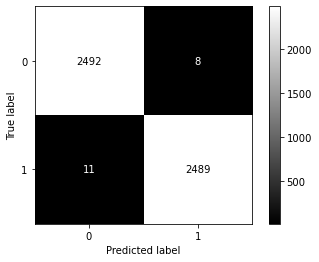

In [29]:
disp = ConfusionMatrixDisplay(cmatrix)
disp.plot(cmap='binary_r')
plt.show()

Now, let's plot out samples from each corner of the matrix.

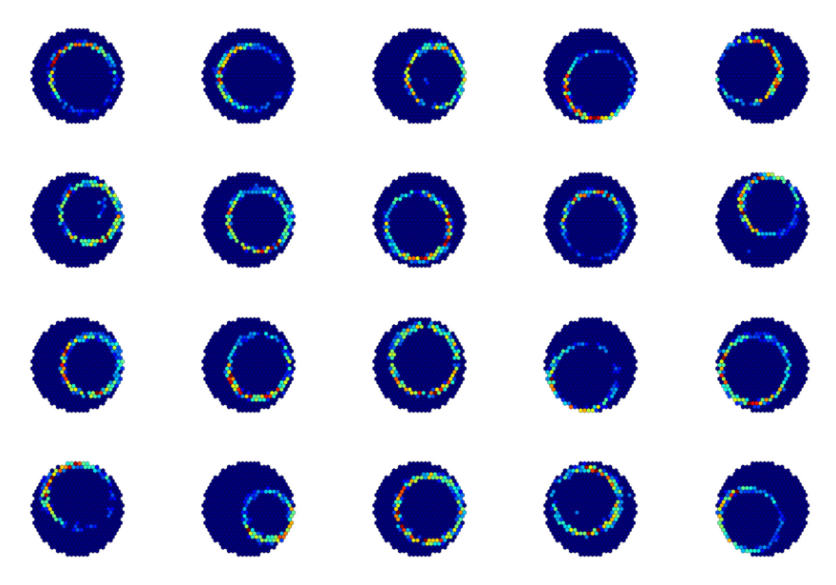

In [21]:
tps = np.where((true_labels==1) & (pred_labels==1))[0]
tp_subject_ids = all_data[tps,0].astype(int)

fig, axs = plt.subplots(4, 5, dpi=150, sharex=True, sharey=True)

for (sub_id, axi) in zip(tp_subject_ids, axs.flatten()):
    img = plt.imread(f'subject_images_resized/{sub_id}.png')
    axi.imshow(img)
    axi.axis('off')
plt.tight_layout()
plt.show()

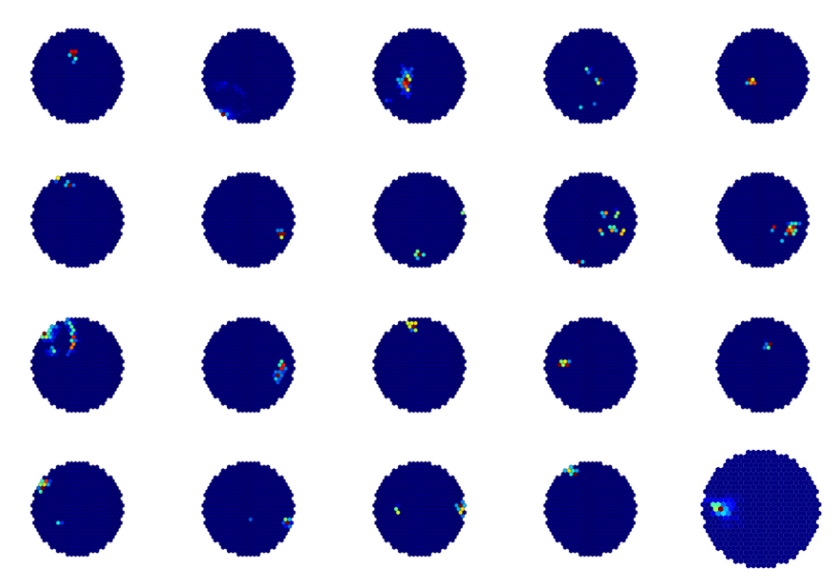

In [22]:
fns = np.where((true_labels==0) & (pred_labels==0))[0]
fn_subject_ids = all_data[fns,0].astype(int)

fig, axs = plt.subplots(4, 5, dpi=150, sharex=True, sharey=True)

for (sub_id, axi) in zip(fn_subject_ids, axs.flatten()):
    img = plt.imread(f'subject_images_resized/{sub_id}.png')
    axi.imshow(img)
    axi.axis('off')
plt.tight_layout()
plt.show()

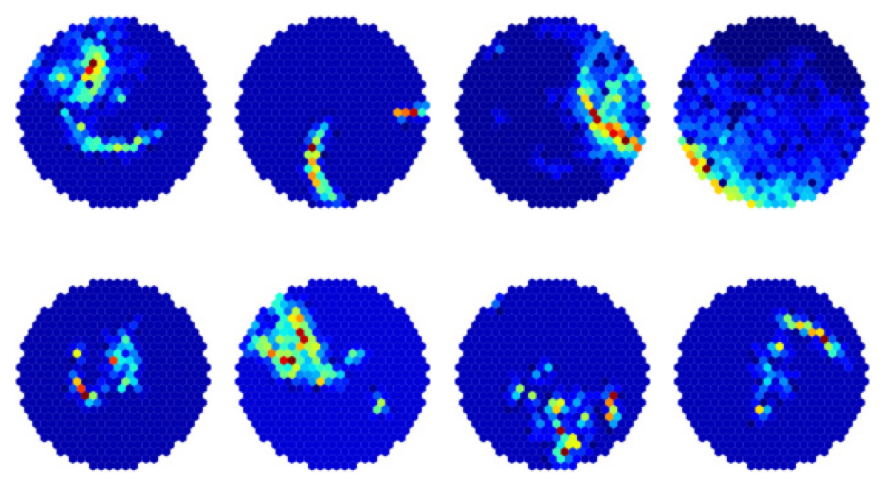

In [25]:
fps = np.where((true_labels==0) & (pred_labels==1))[0]
fp_subject_ids = all_data[fps,0].astype(int)

fig, axs = plt.subplots(2, 4, dpi=150, sharex=True, sharey=True)

for (sub_id, axi) in zip(fp_subject_ids, axs.flatten()):
    img = plt.imread(f'subject_images_resized/{sub_id}.png')
    axi.imshow(img)
    axi.axis('off')
plt.tight_layout()
plt.show()

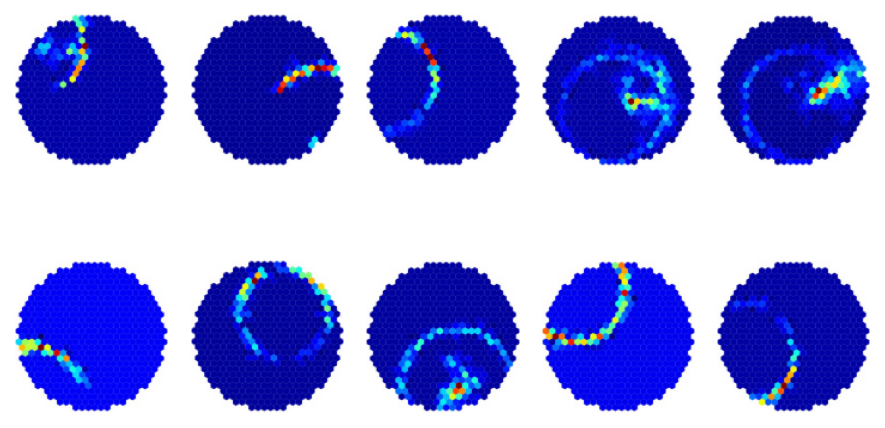

In [24]:
fns = np.where((true_labels==1) & (pred_labels==0))[0]
fn_subject_ids = all_data[fns,0].astype(int)

fig, axs = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True)

for (sub_id, axi) in zip(fn_subject_ids, axs.flatten()):
    img = plt.imread(f'subject_images_resized/{sub_id}.png')
    axi.imshow(img)
    axi.axis('off')
plt.tight_layout()
plt.show()